# Dis14: A/B testing with "Add to cart" conversion 

## Statistical testing for the small change which leads to the conversion

## Problem: optimizing the conversion, in this case is whether changing the "Add to cart" button with larger or brighter fonts will increase conversion.

In [2]:
## Assume that we have 1000 total users
# 550 were directed to site A, 450 to site B. 
# In site A, 48 users converted. In site B, 56 users converted. 
# Is this a statistically significant result?

num_a, num_b = 550, 450
click_a, click_b = 48, 56
rate_a, rate_b = click_a / num_a, click_b / num_b

## 1. Binomial distribution

### Users can click a button, or not. Two discrete options are available, so this is a binomial distribution, with some unknown rate for site A and site B. We don’t know the true click rate, but we can estimate it using our 1000 sample.

In [3]:
import matplotlib.pyplot as plt
from scipy.stats import binom
import numpy as np

# Determine the probability of having x number of click throughs
clicks = np.arange(20, 80)
prob_a = binom(num_a, rate_a).pmf(clicks)
prob_b = binom(num_b, rate_b).pmf(clicks)

# Make the bar plots.
plt.bar(clicks, prob_a, label="A", alpha=0.7)
plt.bar(clicks, prob_b, label="B", alpha=0.7)
plt.legend()
plt.xlabel("Num converted")
plt.ylabel("Probability")
plt.show()

<Figure size 640x480 with 1 Axes>

### So B has an edge, but it's possible if we pick two random points according to the histograms for A and B, that A might actually be higher than B.

## 2. Normal distribution

### As we’re interested in the average conversion, or average time spent on the site, this averaging of an underlying distribution means our final estimate will be well approximated by a normal distribution.

### $std = \sigma = \frac{\sqrt{p(1-p)}}{\sqrt{n}}$
### $\hat{p} \sim Normal(\mu = p, \sigma = \frac{\sqrt{p(1-p)}}{\sqrt{n}})$

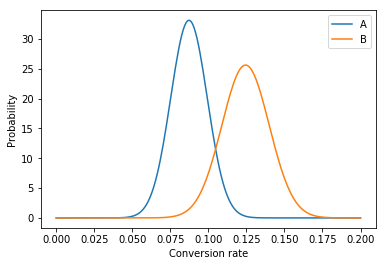

In [4]:
from scipy.stats import norm

# Where does this come from? See the link above.
std_a = np.sqrt(rate_a * (1 - rate_a) / num_a)
std_b = np.sqrt(rate_b * (1 - rate_b) / num_b)

click_rate = np.linspace(0, 0.2, 200)
prob_a = norm(rate_a, std_a).pdf(click_rate)
prob_b = norm(rate_b, std_b).pdf(click_rate)

# Make the bar plots.
plt.plot(click_rate, prob_a, label="A")
plt.plot(click_rate, prob_b, label="B")
plt.legend()
plt.xlabel("Conversion rate"); plt.ylabel("Probability");


### This is a better plot than the first one, because we’ve removed the confusing effect of site A and site B having a slightly different number of visitors had. So our question is still the same: What is the chance that a draw from B is higher than a draw from A. Is it significant ? (Hypothesis Testing)

## 3. One-tailed test (whether B > A)

### The null hypothesis is the position that the change in the design made for the test group would result in no change in the conversion rate. 
($H_0: d = 0$)
### The alternative hypothesis is the opposing position that the change in the design for the test group would result in an improvement (or reduction) in the conversion rate. 
($H_a: d = P_B-P_A$)

$P_B-P_A = Normal(\mu_B-\mu_A, \sqrt{\sigma_A^2+\sigma_B^2})$

zscore is 1.890, with p-value 0.029


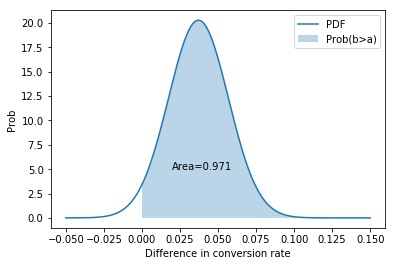

In [5]:
# The difference in the means and sum the variance
z_score = (rate_b - rate_a) / np.sqrt(std_a**2 + std_b**2)
p = norm(rate_b - rate_a, np.sqrt(std_a**2 + std_b**2))

x = np.linspace(-0.05, 0.15, 1000)
y = p.pdf(x)
p_value = norm().sf(z_score)
area_under_curve = p.sf(0)
plt.plot(x, y, label="PDF")
plt.fill_between(x, 0, y, where=x>0, label="Prob(b>a)", alpha=0.3)
plt.annotate(f"Area={area_under_curve:0.3f}", (0.02, 5))
plt.legend()
plt.xlabel("Difference in conversion rate")
plt.ylabel("Prob")

print(f"zscore is {z_score:0.3f}, with p-value {p_value:0.3f}")

### Using frequentist approach so far, we would say that given the null hypothesis is true (that B is less then or equal to A), we would expect to get this result or a result more extreme only 2.9% of the time.
### As that is a significant result (typically p < 5%), we reject the null hypothesis, and state that we have evidence that B > A.

###  The question we’ve asked is if B > A. An alterative is the two-tailed test, where we just want to discriminate that B is different to A. In that case, the p-value is actually 2×2.9=5.8 percent (as we have two tails, not one), and we would want more samples before rejecting the null hypothesis if we apply the p-value 0.05 threshold.

## 4. Permutation Approach

In [6]:
from scipy.stats import bernoulli

# create data for permutation 
# rate_a = 0.087, rate_b = 0.125

data_A = bernoulli(0.087).rvs(550, random_state = 42)
data_B = bernoulli(0.125).rvs(450, random_state = 42)

rate_a = np.count_nonzero(data_A) / 550
rate_b = np.count_nonzero(data_B) / 450
print("empirical rate A:", rate_a)
print("empirical rate B:", rate_b)

empirical rate A: 0.09818181818181818
empirical rate B: 0.13333333333333333


### The null hypothesis is $H_0: $ There is no difference between the means


### randomly assign group A and B with permutation

In [7]:
def permutation_sample(data_A, data_B):
    data = np.concatenate([data_A, data_B])
    permuted_data = np.random.permutation(data)
    permuted_A = permuted_data[:len(data_A)]
    permuted_B = permuted_data[len(data_B):]
    return permuted_A, permuted_B

In [8]:
def diff_of_means(data_A, data_B):
    diff = np.mean(data_A) - np.mean(data_B)
    return diff

### We will work out the difference between the means of the new A and B. This is a permutation replicate. A permutation replicate is the test statistic calculated for a permutation. The test statistic of interest here being the difference in the means.

In [24]:
# The difference means of initial samples
empirical_diff_means = np.mean(data_A) - np.mean(data_B)

# draw the permutation replicate with 200 samples
# Initialise an empty numpy array
perm_replicates = np.empty(200)
for i in range(200):
    perm_A, perm_B = permutation_sample(data_A, data_B)
    perm_replicates[i] = diff_of_means(perm_A, perm_B)

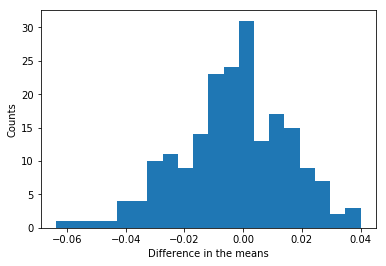

In [25]:
plt.hist(perm_replicates, bins = 20)
plt.xlabel("Difference in the means")
plt.ylabel("Counts")
plt.show()

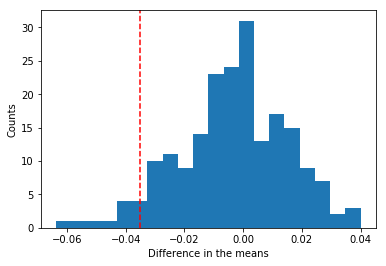

In [26]:
plt.axvline(x=empirical_diff_means,color='r',linestyle='--')
plt.hist(perm_replicates, bins = 20)
plt.xlabel("Difference in the means")
plt.ylabel("Counts")
plt.show()

In [27]:
# draw the permutation replicate with 10000 samples
# Initialise an empty numpy array
perm_replicates = np.empty(10000)
for i in range(10000):
    perm_A, perm_B = permutation_sample(data_A, data_B)
    perm_replicates[i] = diff_of_means(perm_A, perm_B)

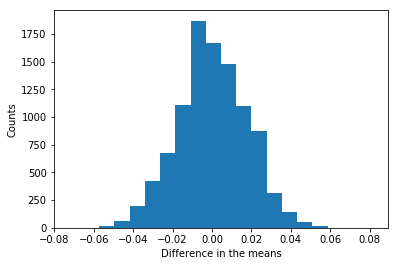

In [28]:
plt.hist(perm_replicates, bins = 20)
plt.xlabel("Difference in the means")
plt.ylabel("Counts")
plt.show()

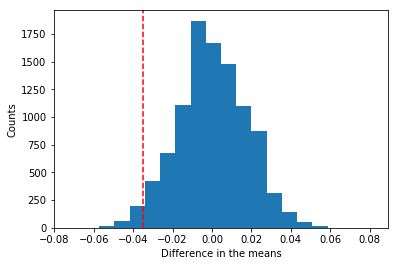

In [29]:
plt.axvline(x=empirical_diff_means,color='r',linestyle='--')
plt.hist(perm_replicates, bins = 20)
plt.xlabel("Difference in the means")
plt.ylabel("Counts")
plt.show()

### The result with more samples are more reliable than the one with smaller samples.

### The p-value of amount of mass of histogram to the left of the red vertical line.

In [15]:
p = np.sum(perm_replicates <= empirical_diff_means) / len(perm_replicates)
# The p-value is less than 0.05
print('p-value =', p)

p-value = 0.0204


### This is very really similar to the p-value generated from the Gaussian and Binomial distribution, but the permutation methodology is more flexible.Therefore, since p-value < 0.05 represents evidence to reject the null hypothesis and conclude that there is a difference between the conversion rates of experiments A and B. 